In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from oneDtoyTask.oneDtoyTask import ToyTask, OneDfield, TwoWayComChannel
from agents.agent_AriaRE import AriaRE
from agents.agent_AriaAC import AriaAC, ariaModel
from IPython import display
import wandb

In [26]:
class test_m(nn.Module):
    def __init__(self):
        super(test_m, self).__init__()
        self.l = nn.Sequential(nn.Linear(1, 5), nn.ReLU(), nn.Linear(5, 1), nn.Sigmoid())
        self.v = nn.Sequential(nn.Linear(1, 5), nn.ReLU(), nn.Linear(5, 1))
    def forward(self, x):
        return self.l(x), self.v(x)

mA = ariaModel(batch_size=1, vocabulary_size=4, hidden_dim=10, memory_size=8, with_memory=True)
optimizer = torch.optim.Adam(mA.parameters(), lr=0.01)
rewards = []
v_losses = []
p_losses = []
hid_state = torch.zeros([1, 2*8])
for _ in range(1000):
    optimizer.zero_grad()
    m0 = torch.tensor(np.zeros([1, 4]))
    i = np.random.randint(0, 2, size=[1, 2])
    i = torch.tensor(i, dtype=torch.int32)
    action, message, hid_state, val = mA(i.float(), m0.float(), hid_state.detach())
    a_distrib = torch.distributions.Categorical(torch.cat([action, 1-action], -1))
    m_distrib = torch.distributions.Categorical(message)
    m = m_distrib.sample()
    m_lp = m_distrib.log_prob(m)
    a = a_distrib.sample()
    a_lp = a_distrib.log_prob(a)
    reward = int(a==1)
    adv = reward - val
    policy_loss = -(a_lp+m_lp)*adv
    value_loss = adv.pow(2)
    loss = policy_loss + value_loss
    loss.backward(retain_graph=True)
    optimizer.step()
    rewards.append(reward)
    v_losses.append(value_loss.detach().item())
    p_losses.append(policy_loss.detach().item())

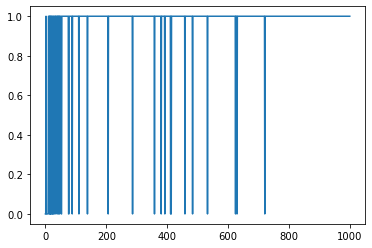

In [27]:
plt.plot(rewards)

In [28]:
epochs = 1000
opt_params = {"lr":0.01, "training_loops":1, "batch_size":28, \
              "replay_size": 30, "gamma":0.9, "vocab_size":4, \
              "memory_size":8, "eps":0.001}
agent0 = AriaAC(opt_params=opt_params, with_memory=True, aidi=0).float()
agent1 = AriaAC(opt_params=opt_params, with_memory=True, aidi=1).float()
np.random.seed(1)
field = OneDfield(speed=1)
Task = ToyTask(field=field, observationMappingFct=lambda x: (x>0.5).astype(int), comChannel=TwoWayComChannel())



KeyError: 'memory_size'

In [3]:
def plot_preds(obsers, preds):
    display.clear_output(wait=True)
    plt.clf()
    obsers = np.array(obsers)
    preds = np.array(preds)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].plot(obsers[:, 0])
    axs[0].plot(preds[:, 0])
    axs[0].legend(['observations', 'predictions'])
    axs[0].set_title('Agent 0')
    axs[0].set_xlabel('Epoch')

    axs[1].plot(obsers[:, 1])
    axs[1].plot(preds[:, 1])
    axs[1].legend(['observations', 'predictions'])
    axs[1].set_title('Agent 1')
    axs[1].set_xlabel('Epoch')
    plt.grid(True)
    
    display.display(plt.gcf())
    return fig

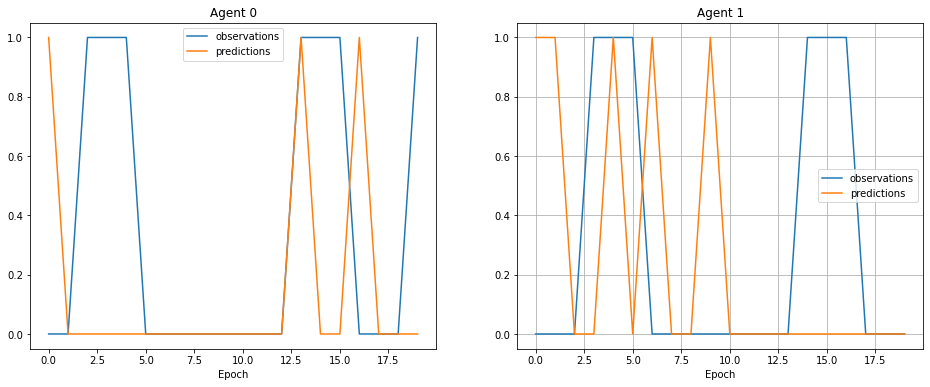

epoch 580/1000 
[policy loss, value loss, entropy loss], reward:  
agent 0 [ 1.82  1.9  -0.35], 1.15 mean policy 0.7484056353569031 
agent 1 [ 2.04  1.99 -0.34], 1.15 mean policy 0.6895983219146729
epoch 581/1000 
[policy loss, value loss, entropy loss], reward:  
agent 0 [ 1.55  1.5  -0.36], 1.0 mean policy 0.6770192980766296 
agent 1 [ 1.46  1.57 -0.35], 1.0 mean policy 0.7605148553848267
epoch 582/1000 
[policy loss, value loss, entropy loss], reward:  
agent 0 [ 2.25  3.   -0.34], 1.7 mean policy 0.8429688215255737 
agent 1 [ 2.4   3.03 -0.32], 1.7 mean policy 0.8969488143920898


KeyboardInterrupt: 

In [4]:
obs, downlink_msgs = Task.reset()
losses = []
rewards1 = []
rewards2 = []
epoch = 0
observations = []
predictions = []
while epoch<epochs:
    
    a0, m0u=  agent0.select_action(obs[0], downlink_msgs[0])
    a1, m1u= agent1.select_action(obs[1], downlink_msgs[1])
    mu_ = np.zeros((2, opt_params["vocab_size"]))
    mu_[0, m0u.item()] = 1
    mu_[1, m1u.item()] = 1
    
    predictions.append((a0.item(), a1.item()))
    (obs_, downlink_msgs_), r, done = Task.step([a0.item(), a1.item()], [mu_[0], mu_[1]])
    observations.append([obs_[0][1], obs_[1][0]])
    loss0, rew0, mean_policy0 = agent0.train_on_batch([obs[0], Task.initMsgs[0]], r[0])
    loss1, rew1, mean_policy1 = agent1.train_on_batch([obs[1], Task.initMsgs[1]], r[1])
    obs = obs_
    downlink_msgs = downlink_msgs_
    if loss0 is not None:
        
        #wandb.log({"policy loss A0": loss0[0], "value loss A0": loss0[1], \
        #           "entropy loss A0": loss0[2],"reward A0": np.mean(rew0), \
        #           "policy loss A1": loss1[0], "value loss A1": loss1[1], \
        #           "entropy loss A1": loss1[2], "reward A1": np.mean(rew1),\
        #           "mean policy A0": mean_policy0, "mean policy A1": mean_policy1})
        

        losses.append([loss0, loss1])
        rewards1.append(rew0)
        rewards1.append(rew1)
        if epoch%50==0:
            #im0, im1 = get_images(np.array(observations), np.array(predictions))
            #table = wandb.Table(columns=["Epoch#", "batch_pred A0", "batch_pred A1"])
            print("Training epoch ", epoch)
            #table.add_data(epoch,  wandb.Image(im0),  wandb.Image(im1))
            #run.log({"Batch Predictions": table})
        epoch+=1
        observations = []
        predictions = []

